<a href="https://colab.research.google.com/github/94jjiisu/Data-analysis/blob/master/bead_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install -U pandas-profiling
#!pip install eli5

In [2]:
import pandas as pd
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from pandas_profiling import ProfileReport


from sklearn.model_selection import train_test_split, validation_curve, RandomizedSearchCV, GridSearchCV
from scipy.stats import randint, uniform

import graphviz

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler, LabelEncoder

from sklearn.metrics import plot_confusion_matrix, accuracy_score, classification_report, f1_score, roc_auc_score, roc_curve

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsRestClassifier


from sklearn.decomposition import PCA

# KNN, 다층퍼셉트론, SVM
import eli5
from eli5.sklearn import PermutationImportance
import warnings
warnings.filterwarnings('ignore')

warnings.simplefilter(action='ignore', category=FutureWarning)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
filename = "/content/drive/MyDrive/DS_camp/session2/Dry_Bean_Dataset.xlsx"

df = pd.read_excel(filename)

In [5]:
df.head()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,SEKER
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272750,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,SEKER
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,SEKER
3,30008,645.884,210.557999,182.516516,1.153638,0.498616,30724,195.467062,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199,SEKER
4,30140,620.134,201.847882,190.279279,1.060798,0.333680,30417,195.896503,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.941900,0.999166,SEKER


In [6]:
df.isna().sum().sort_values()

Area               0
ShapeFactor3       0
ShapeFactor2       0
ShapeFactor1       0
Compactness        0
roundness          0
Solidity           0
ShapeFactor4       0
Extent             0
ConvexArea         0
Eccentricity       0
AspectRation       0
MinorAxisLength    0
MajorAxisLength    0
Perimeter          0
EquivDiameter      0
Class              0
dtype: int64

In [7]:
df.duplicated().sum()

68

In [8]:
df.drop_duplicates(keep='first', inplace=True)
df.reset_index(drop=True, inplace=True)

In [9]:
df.Class.value_counts()

DERMASON    3546
SIRA        2636
SEKER       2027
HOROZ       1860
CALI        1630
BARBUNYA    1322
BOMBAY       522
Name: Class, dtype: int64

In [10]:
df.head(3)

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,SEKER
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272750,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,SEKER
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,SEKER


In [11]:
# COLUMNS = df.columns.tolist()

# feature_cols = COLUMNS[:-1]
# sns.set(style='darkgrid')
# fig, ax_list = plt.subplots(nrows=4, ncols=4, sharey=False, figsize=(36,24))
# ax_list = ax_list.flatten()
# for name, ax in zip(feature_cols, ax_list):
#      g = sns.histplot(df, x=name, bins=10, ax=ax).set(title=name)

In [12]:
sns.scatterplot(x=df['MajorAxisLength'], y=df['MinorAxisLength'], hue=df['Class'])

In [13]:
# profile = ProfileReport(df, minimal=True).to_notebook_iframe()

In [14]:
#le = LabelEncoder()
#df['Class'] = le.fit_transform(df.Class)
#df['Class']

In [15]:
target = 'Class'

label = df[target]
features = df.drop([target], axis=1)

In [16]:
scaler = StandardScaler()
Z = scaler.fit_transform(features)

output = pd.DataFrame(Z, columns=features.columns, index=list(features.index.values))

In [17]:
pca = PCA(2)
df_pca= pca.fit_transform(output)
df_pca = pd.DataFrame(data = df_pca, columns=['PC1', 'PC2'])

In [18]:
df_pca['Class'] = label

In [19]:
plt.figure(figsize=(14,14))
sns.scatterplot(x = 'PC1', y = 'PC2', data = df_pca, hue = 'Class');

In [20]:
area = df['Area'].groupby(df['Class']).mean().sort_values()

In [21]:
sns.barplot(x = area.index, y = area.values);

In [22]:
target = 'Class'

train, test = train_test_split(df, train_size=0.80, test_size=0.20, 
                              stratify=df[target], random_state=2)

train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train[target], random_state=2)

train.shape, val.shape, test.shape

((8667, 17), (2167, 17), (2709, 17))

In [23]:
train[target].value_counts(normalize=True)

DERMASON    0.261913
SIRA        0.194646
SEKER       0.149648
HOROZ       0.137302
CALI        0.120342
BARBUNYA    0.097612
BOMBAY      0.038537
Name: Class, dtype: float64

In [24]:
val[target].value_counts(normalize=True)

DERMASON    0.261652
SIRA        0.194739
SEKER       0.149515
HOROZ       0.137517
CALI        0.120443
BARBUNYA    0.097370
BOMBAY      0.038763
Name: Class, dtype: float64

In [25]:
test[target].value_counts(normalize=True)

DERMASON    0.261720
SIRA        0.194537
SEKER       0.149871
HOROZ       0.137320
CALI        0.120340
BARBUNYA    0.097822
BOMBAY      0.038391
Name: Class, dtype: float64

In [26]:
features = train.drop(columns=[target]).columns

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

In [27]:
dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(X_train, y_train)

predict = dt_clf.predict(X_val)
f1=f1_score(y_val, predict, average='weighted')

print("F1 score: {}" .format(f1))

F1 score: 0.8891375007155944


In [28]:
predict = dt_clf.predict(X_test)
f1=f1_score(y_test, predict, average='weighted')


print("F1 score: {}" .format(f1))

F1 score: 0.8959994964512971


In [29]:
confusion = pd.DataFrame({'Class': test['Class'], 'Predict': predict})
# Create crosstab: ct
ct = pd.crosstab(confusion['Predict'], confusion['Class'])

ct

Class,BARBUNYA,BOMBAY,CALI,DERMASON,HOROZ,SEKER,SIRA
Predict,,,,,,,
BARBUNYA,243,1,22,0,5,3,7
BOMBAY,0,103,0,0,0,0,0
CALI,14,0,293,0,7,1,3
DERMASON,0,0,0,622,3,13,56
HOROZ,0,0,7,5,342,0,14
SEKER,4,0,1,13,0,385,8
SIRA,4,0,3,69,15,4,439


In [30]:
model_dt = dt_clf

importances = pd.Series(model_dt.feature_importances_, X_train.columns)
plt.figure(figsize=(10,14))
importances.sort_values().plot.barh();

In [31]:
ft1 = train['ShapeFactor1'].groupby(df['Class']).mean().sort_values()

sns.barplot(x = ft1.index, y = ft1.values);

In [32]:
ft3 = train['ShapeFactor3'].groupby(df['Class']).mean().sort_values()

sns.barplot(x = ft3.index, y = ft3.values);

In [33]:
pipe = make_pipeline(
    RobustScaler(), 
    RandomForestClassifier(random_state=42, n_jobs=-1)
)

params = {
    'randomforestclassifier__class_weight' : [None],
    'randomforestclassifier__max_depth' : [16],
    'randomforestclassifier__n_estimators' : [550],
    'randomforestclassifier__min_samples_leaf' : [4],
    'randomforestclassifier__max_features' : ['auto']
}

clf1 = GridSearchCV(
    pipe,
    param_grid=params,
    cv=5,
    n_jobs=-1
    )

clf1.fit(X_train, y_train)


print('최적 하이퍼파라미터: ', clf1.best_params_)
print('accuracy: ', clf1.best_score_)

m1 = clf1.best_estimator_

m1.fit(X_val, y_val)
print('검증 정확도', m1.score(X_val, y_val))

predict = m1.predict(X_val)
f1=f1_score(y_val, predict, average='weighted')

print("F1 score: {}" .format(f1))


최적 하이퍼파라미터:  {'randomforestclassifier__class_weight': None, 'randomforestclassifier__max_depth': 16, 'randomforestclassifier__max_features': 'auto', 'randomforestclassifier__min_samples_leaf': 4, 'randomforestclassifier__n_estimators': 550}
accuracy:  0.9208500969377263
검증 정확도 0.9584679280110752
F1 score: 0.958391035244608


In [34]:
'''
최적 하이퍼파라미터:  {'randomforestclassifier__class_weight': None, 'randomforestclassifier__max_depth': 12,
                       'randomforestclassifier__max_features': 'auto', 'randomforestclassifier__min_samples_leaf': 10, 
                       'randomforestclassifier__n_estimators': 300}
accuracy:  0.9184271529459684
검증 정확도 0.9358560221504384
F1 score: 0.9358783932572229
'''

"\n최적 하이퍼파라미터:  {'randomforestclassifier__class_weight': None, 'randomforestclassifier__max_depth': 12,\n                       'randomforestclassifier__max_features': 'auto', 'randomforestclassifier__min_samples_leaf': 10, \n                       'randomforestclassifier__n_estimators': 300}\naccuracy:  0.9184271529459684\n검증 정확도 0.9358560221504384\nF1 score: 0.9358783932572229\n"

In [35]:
'''
최적 하이퍼파라미터:  {'randomforestclassifier__class_weight': None, 'randomforestclassifier__max_depth': 14, 'randomforestclassifier__max_features': 'auto', 'randomforestclassifier__min_samples_leaf': 6, 'randomforestclassifier__n_estimators': 500}
accuracy:  0.9198118349882296
검증 정확도 0.946931241347485
F1 score: 0.946882781500124
'''

"\n최적 하이퍼파라미터:  {'randomforestclassifier__class_weight': None, 'randomforestclassifier__max_depth': 14, 'randomforestclassifier__max_features': 'auto', 'randomforestclassifier__min_samples_leaf': 6, 'randomforestclassifier__n_estimators': 500}\naccuracy:  0.9198118349882296\n검증 정확도 0.946931241347485\nF1 score: 0.946882781500124\n"

In [36]:
# 최적 하이퍼파라미터:  {'randomforestclassifier__class_weight': None, 'randomforestclassifier__max_depth': 16, 
#                        'randomforestclassifier__max_features': 'auto', 'randomforestclassifier__min_samples_leaf': 4, 
#                        'randomforestclassifier__n_estimators': 550}
# accuracy:  0.9208500969377263
# 검증 정확도 0.9584679280110752
# F1 score: 0.958391035244608


In [37]:
confusion = pd.DataFrame({'Class': val['Class'], 'Predict': predict})
# Create crosstab: ct
ct = pd.crosstab(confusion['Predict'], confusion['Class'])

ct

Class,BARBUNYA,BOMBAY,CALI,DERMASON,HOROZ,SEKER,SIRA
Predict,,,,,,,
BARBUNYA,193,0,0,0,2,1,1
BOMBAY,0,83,0,0,0,0,0
CALI,9,1,254,0,2,0,0
DERMASON,0,0,0,554,2,4,19
HOROZ,3,0,6,0,287,0,3
SEKER,1,0,1,5,0,312,5
SIRA,5,0,0,8,5,7,394


In [38]:
print(classification_report(predict, val['Class']))

              precision    recall  f1-score   support

    BARBUNYA       0.91      0.98      0.95       197
      BOMBAY       0.99      1.00      0.99        83
        CALI       0.97      0.95      0.96       266
    DERMASON       0.98      0.96      0.97       579
       HOROZ       0.96      0.96      0.96       299
       SEKER       0.96      0.96      0.96       324
        SIRA       0.93      0.94      0.94       419

    accuracy                           0.96      2167
   macro avg       0.96      0.96      0.96      2167
weighted avg       0.96      0.96      0.96      2167



In [39]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [40]:
from sklearn.utils import class_weight
classes_weights = class_weight.compute_sample_weight('balanced', y_train)

In [41]:
X_train

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4
7334,69452,1053.073,426.823196,210.749841,2.025260,0.869596,70718,297.370195,0.824307,0.982098,0.787005,0.696706,0.006146,0.000893,0.485399,0.983059
6574,54987,946.884,401.506883,176.323788,2.277100,0.898411,55691,264.597095,0.753825,0.987359,0.770684,0.659010,0.007302,0.000850,0.434294,0.988932
2571,67686,1044.470,368.601069,234.202503,1.573856,0.772198,69063,293.565141,0.708383,0.980062,0.779681,0.796431,0.005446,0.001352,0.634302,0.998299
258,34847,686.633,236.426224,188.062658,1.257167,0.606034,35229,210.638502,0.761018,0.989157,0.928808,0.890927,0.006785,0.002637,0.793751,0.997878
4520,72575,1045.603,412.245965,226.372175,1.821098,0.835744,73615,303.982499,0.784586,0.985872,0.834187,0.737381,0.005680,0.001036,0.543731,0.990188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217,34509,668.332,230.329486,190.919741,1.206420,0.559399,34776,209.614464,0.783654,0.992322,0.970863,0.910064,0.006674,0.002824,0.828216,0.999176
7630,39028,733.184,272.167639,183.205367,1.485588,0.739520,39505,222.917009,0.766969,0.987926,0.912347,0.819043,0.006974,0.001936,0.670831,0.996579
4730,75297,1042.473,401.414812,240.355003,1.670091,0.800921,76241,309.630615,0.717729,0.987618,0.870679,0.771348,0.005331,0.001164,0.594978,0.993668
7798,40400,745.966,274.757788,187.568921,1.464836,0.730727,40832,226.801406,0.707469,0.989420,0.912333,0.825459,0.006801,0.001948,0.681383,0.998115


In [42]:
model = XGBClassifier(
    n_estimators=1000,  
    max_depth=12,        
    learning_rate=0.2,
    scale_pos_weight=classes_weights,
    n_jobs=-1
)

eval_set = [(X_train_scaled, y_train), 
            (X_val_scaled, y_val)]

model.fit(X_train_scaled, y_train, 
          eval_set=eval_set,
          eval_metric='mlogloss',
          early_stopping_rounds=30
         ) 

[0]	validation_0-mlogloss:1.36626	validation_1-mlogloss:1.39301
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 30 rounds.
[1]	validation_0-mlogloss:1.05788	validation_1-mlogloss:1.10572
[2]	validation_0-mlogloss:0.84784	validation_1-mlogloss:0.913119
[3]	validation_0-mlogloss:0.691133	validation_1-mlogloss:0.771623
[4]	validation_0-mlogloss:0.56999	validation_1-mlogloss:0.664705
[5]	validation_0-mlogloss:0.473878	validation_1-mlogloss:0.579489
[6]	validation_0-mlogloss:0.397424	validation_1-mlogloss:0.511732
[7]	validation_0-mlogloss:0.335649	validation_1-mlogloss:0.458636
[8]	validation_0-mlogloss:0.284638	validation_1-mlogloss:0.416574
[9]	validation_0-mlogloss:0.242954	validation_1-mlogloss:0.381806
[10]	validation_0-mlogloss:0.20854	validation_1-mlogloss:0.353509
[11]	validation_0-mlogloss:0.179744	validation_1-mlogloss:0.330191
[12]	validation_0-mlogloss:0.156022	validation

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.2, max_delta_step=0, max_depth=12,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1,
              scale_pos_weight=array([1.04045618, 1.04045618, 1.46352584, ..., 1.18709766, 0.73393175,
       0.95462055]),
              seed=None, silent=None, subsample=1, verbosity=1)

In [43]:
results = model.evals_result()
train_error = results['validation_0']['mlogloss']
val_error = results['validation_1']['mlogloss']

epoch = range(1, len(train_error)+1)
plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, val_error, label='Validation')
plt.ylabel('Classification Error')
plt.xlabel('Model Complexity (n_estimators)')
#plt.ylim((0.15, 0.25)) # Zoom in
plt.legend();

In [44]:
print('검증 정확도', model.score(X_val_scaled, y_val))

print(classification_report(y_val, model.predict(X_val_scaled)))

검증 정확도 0.9229349330872173
              precision    recall  f1-score   support

    BARBUNYA       0.93      0.93      0.93       211
      BOMBAY       1.00      1.00      1.00        84
        CALI       0.95      0.95      0.95       261
    DERMASON       0.92      0.91      0.92       567
       HOROZ       0.97      0.94      0.95       298
       SEKER       0.93      0.92      0.92       324
        SIRA       0.86      0.89      0.87       422

    accuracy                           0.92      2167
   macro avg       0.94      0.94      0.94      2167
weighted avg       0.92      0.92      0.92      2167



In [45]:
predict = model.predict(X_val_scaled)
f1=f1_score(y_val, predict, average='weighted')
print("F1 score: {}" .format(f1))

F1 score: 0.923162444093728


In [46]:
confusion = pd.DataFrame({'Class': val['Class'], 'Predict': predict})
# Create crosstab: ct
ct = pd.crosstab(confusion['Predict'], confusion['Class'])

print(classification_report(predict, val['Class']))

ct

              precision    recall  f1-score   support

    BARBUNYA       0.93      0.93      0.93       211
      BOMBAY       1.00      1.00      1.00        84
        CALI       0.95      0.95      0.95       259
    DERMASON       0.91      0.92      0.92       562
       HOROZ       0.94      0.97      0.95       291
       SEKER       0.92      0.93      0.92       323
        SIRA       0.89      0.86      0.87       437

    accuracy                           0.92      2167
   macro avg       0.94      0.94      0.94      2167
weighted avg       0.92      0.92      0.92      2167



Class,BARBUNYA,BOMBAY,CALI,DERMASON,HOROZ,SEKER,SIRA
Predict,,,,,,,
BARBUNYA,197,0,6,0,3,3,2
BOMBAY,0,84,0,0,0,0,0
CALI,9,0,247,0,3,0,0
DERMASON,0,0,0,517,3,5,37
HOROZ,2,0,6,0,281,0,2
SEKER,1,0,1,16,0,299,6
SIRA,2,0,1,34,8,17,375


In [47]:
# model = LGBMClassifier(
#     n_estimators=500,  
#     max_depth=12,        
#     learning_rate=0.2,
#     scale_pos_weight=classes_weights,
#     n_jobs=-1
# )

# eval_set = [(X_train_scaled, y_train), 
#             (X_val_scaled, y_val)]

# model.fit(X_train_scaled, y_train, 
#           eval_set=eval_set,
#           eval_metric='mlogloss',
#           early_stopping_rounds=30
#          ) 

In [48]:
lgbm_wrapper = LGBMClassifier(n_estimators=500)

evals = [(X_val_scaled, y_val)]
lgbm_wrapper.fit(X_train_scaled, y_train, early_stopping_rounds=100, eval_metric='logloss', eval_set=evals, verbose=True)
preds = lgbm_wrapper.predict(X_val_scaled)
pred_proba = lgbm_wrapper.predict_proba(X_val_scaled)[:,1]

[1]	valid_0's multi_logloss: 1.54009	valid_0's multi_logloss: 1.54009
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's multi_logloss: 1.35007	valid_0's multi_logloss: 1.35007
[3]	valid_0's multi_logloss: 1.20253	valid_0's multi_logloss: 1.20253
[4]	valid_0's multi_logloss: 1.08333	valid_0's multi_logloss: 1.08333
[5]	valid_0's multi_logloss: 0.982695	valid_0's multi_logloss: 0.982695
[6]	valid_0's multi_logloss: 0.89701	valid_0's multi_logloss: 0.89701
[7]	valid_0's multi_logloss: 0.823699	valid_0's multi_logloss: 0.823699
[8]	valid_0's multi_logloss: 0.759501	valid_0's multi_logloss: 0.759501
[9]	valid_0's multi_logloss: 0.702979	valid_0's multi_logloss: 0.702979
[10]	valid_0's multi_logloss: 0.652911	valid_0's multi_logloss: 0.652911
[11]	valid_0's multi_logloss: 0.609211	valid_0's multi_logloss: 0.609211
[12]	valid_0's multi_logloss: 0.570076	valid_0's multi_logloss: 0.570076
[13]	valid_0's multi_logloss: 0.53498	valid_0's multi_logloss: 0.53498
[14]	vali

In [49]:
predict = lgbm_wrapper.predict(X_val_scaled)
f1=f1_score(y_val, predict, average='weighted')
print("F1 score: {}" .format(f1))

confusion = pd.DataFrame({'Class': val['Class'], 'Predict': predict})
# Create crosstab: ct
ct = pd.crosstab(confusion['Predict'], confusion['Class'])

print(classification_report(predict, val['Class']))

ct

F1 score: 0.9204175312474705
              precision    recall  f1-score   support

    BARBUNYA       0.93      0.92      0.93       214
      BOMBAY       1.00      1.00      1.00        84
        CALI       0.94      0.95      0.94       258
    DERMASON       0.91      0.92      0.91       561
       HOROZ       0.94      0.96      0.95       292
       SEKER       0.93      0.93      0.93       321
        SIRA       0.88      0.85      0.86       437

    accuracy                           0.92      2167
   macro avg       0.93      0.93      0.93      2167
weighted avg       0.92      0.92      0.92      2167



Class,BARBUNYA,BOMBAY,CALI,DERMASON,HOROZ,SEKER,SIRA
Predict,,,,,,,
BARBUNYA,197,0,9,0,2,3,3
BOMBAY,0,84,0,0,0,0,0
CALI,8,0,245,0,5,0,0
DERMASON,0,0,0,516,3,4,38
HOROZ,2,0,5,0,281,0,4
SEKER,0,0,1,14,0,300,6
SIRA,4,0,1,37,7,17,371


In [50]:
y_train

7334       HOROZ
6574       HOROZ
2571    BARBUNYA
258        SEKER
4520        CALI
          ...   
217        SEKER
7630        SIRA
4730        CALI
7798        SIRA
372        SEKER
Name: Class, Length: 8667, dtype: object

In [51]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train) 
y_val_enc = le.fit_transform(y_val)
y_test_enc = le.fit_transform(y_test)

In [52]:
lgbm_clf = LGBMClassifier(n_estimators=500)

params = {'num_leaves': [32, 64],
          'max_depth':[128, 160],
          'min_child_samples':[60, 100],
          'sumsample':[0.8, 1]}

gridcv= GridSearchCV(lgbm_clf, param_grid=params, cv = 5)
gridcv.fit(X_train_scaled, y_train_enc, early_stopping_rounds=30, eval_metric='logloss', eval_set=[(X_train, y_train_enc),(X_val_scaled, y_val_enc)])

print('최적 파라미터:', gridcv.best_params_)


[1]	valid_0's multi_logloss: 1.89201	valid_0's multi_logloss: 1.89201	valid_1's multi_logloss: 1.55067	valid_1's multi_logloss: 1.55067
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's multi_logloss: 1.95265	valid_0's multi_logloss: 1.95265	valid_1's multi_logloss: 1.36475	valid_1's multi_logloss: 1.36475
[3]	valid_0's multi_logloss: 2.00905	valid_0's multi_logloss: 2.00905	valid_1's multi_logloss: 1.21975	valid_1's multi_logloss: 1.21975
[4]	valid_0's multi_logloss: 2.04682	valid_0's multi_logloss: 2.04682	valid_1's multi_logloss: 1.10136	valid_1's multi_logloss: 1.10136
[5]	valid_0's multi_logloss: 2.08426	valid_0's multi_logloss: 2.08426	valid_1's multi_logloss: 1.0016	valid_1's multi_logloss: 1.0016
[6]	valid_0's multi_logloss: 2.13735	valid_0's multi_logloss: 2.13735	valid_1's multi_logloss: 0.916741	valid_1's multi_logloss: 0.916741
[7]	valid_0's multi_logloss: 2.18533	valid_0's multi_logloss: 2.18533	valid_1's multi_logloss: 0.842968	valid_1's multi_lo

In [53]:
m2 = gridcv.best_estimator_

m2.fit(X_val_scaled, y_val_enc)
print('검증 정확도', m2.score(X_test_scaled, y_test_enc))

predict = m2.predict(X_test_scaled)
f1=f1_score(y_test_enc, predict, average='weighted')

print("F1 score: {}" .format(f1))

검증 정확도 0.9224806201550387
F1 score: 0.9227475033564652


In [54]:
import tensorflow as tf
from tensorflow import keras

# 헬퍼(helper) 라이브러리를 임포트합니다
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.7.0


In [55]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
  except RuntimeError as e:
    # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
    print(e)

In [56]:
X_train_scaled.shape

(8667, 16)

In [57]:
len(y_train_enc)

8667

In [58]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

In [59]:
def build_model():
  model = Sequential()
  model.add(Dense(128, activation='selu', input_dim=16))
  model.add(Dense(64, activation='selu'))
  model.add(Dense(7, activation='softmax'))

  model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
  
  return model

In [60]:
# model = keras.Sequential([
#     keras.layers.Flatten(input_shape=(16,)),
#     keras.layers.Dense(128, activation='relu'),
#     keras.layers.Dense(64, activation='relu'),
#     keras.layers.Dense(7, activation='softmax')
# ])

In [61]:
# model.compile(optimizer='adam',
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])

In [62]:
# model.fit(X_train_scaled, y_train, epochs=100)

In [63]:
# test_loss, test_acc = model.evaluate(X_val_scaled,  y_val_enc, verbose=2)

# print('\n테스트 정확도:', test_acc)

In [64]:
model = build_model()

In [66]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping()

In [68]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

In [69]:
history = model.fit(X_train_scaled, y_train_enc, epochs=200, batch_size=32, verbose=2, 
                    validation_data=(X_val_scaled, y_val_enc), callbacks=[early_stopping])


Epoch 1/200
271/271 - 1s - loss: 0.3880 - accuracy: 0.8725 - val_loss: 0.2340 - val_accuracy: 0.9225 - 1s/epoch - 5ms/step
Epoch 2/200
271/271 - 1s - loss: 0.2317 - accuracy: 0.9167 - val_loss: 0.2260 - val_accuracy: 0.9174 - 566ms/epoch - 2ms/step
Epoch 3/200
271/271 - 1s - loss: 0.2222 - accuracy: 0.9200 - val_loss: 0.2266 - val_accuracy: 0.9188 - 559ms/epoch - 2ms/step
Epoch 4/200
271/271 - 1s - loss: 0.2165 - accuracy: 0.9222 - val_loss: 0.2183 - val_accuracy: 0.9229 - 553ms/epoch - 2ms/step
Epoch 5/200
271/271 - 1s - loss: 0.2125 - accuracy: 0.9218 - val_loss: 0.2146 - val_accuracy: 0.9229 - 557ms/epoch - 2ms/step
Epoch 6/200
271/271 - 1s - loss: 0.2085 - accuracy: 0.9240 - val_loss: 0.2165 - val_accuracy: 0.9197 - 571ms/epoch - 2ms/step
Epoch 7/200
271/271 - 1s - loss: 0.2086 - accuracy: 0.9263 - val_loss: 0.2088 - val_accuracy: 0.9266 - 554ms/epoch - 2ms/step
Epoch 8/200
271/271 - 1s - loss: 0.2032 - accuracy: 0.9251 - val_loss: 0.2163 - val_accuracy: 0.9206 - 610ms/epoch - 2ms/

In [70]:
model.evaluate(X_val_scaled, y_val_enc)

68/68 [==============================] - 0s 2ms/step - loss: 0.2039 - accuracy: 0.9299


[0.20387551188468933, 0.9298569560050964]

In [71]:
# model = build_model()
# history = model.fit(X_train_scaled, y_train_enc, batch_size=32, epochs=200, validation_split=0.25, verbose=2)


In [73]:
model.evaluate(X_test_scaled, y_test_enc)

85/85 [==============================] - 0s 1ms/step - loss: 0.1604 - accuracy: 0.9398


[0.1604497730731964, 0.9398301839828491]

In [74]:
y_pred_proba = model.predict(X_test_scaled)
y_pred_proba[:5]

array([[9.7904646e-01, 1.0309270e-06, 1.4965223e-02, 1.5322933e-06,
        3.4494938e-03, 1.2367575e-04, 2.4125045e-03],
       [1.5702113e-03, 2.3168455e-07, 1.5430717e-04, 2.4386237e-03,
        1.4108558e-03, 1.0087924e-04, 9.9432486e-01],
       [2.5303018e-06, 3.6297507e-10, 3.9254605e-06, 5.6498653e-08,
        9.9998069e-01, 7.6575624e-08, 1.2605516e-05],
       [9.1673792e-07, 4.3617911e-06, 4.2621133e-07, 9.6826196e-01,
        8.8148972e-04, 3.7777671e-04, 3.0473121e-02],
       [1.9698457e-03, 4.7975973e-06, 9.9793565e-01, 2.8384805e-12,
        8.5473046e-05, 4.1129820e-06, 7.4343987e-08]], dtype=float32)

In [75]:
y_pred_label = np.argmax(y_pred_proba, axis=-1)
y_pred_label[:10]

array([0, 6, 4, 3, 2, 3, 4, 3, 3, 5])

In [76]:
y_test_enc[:10]

array([0, 6, 4, 3, 2, 3, 4, 3, 3, 5])

In [77]:
f1=f1_score(y_test_enc, y_pred_label, average='weighted')
print("F1 score: {}" .format(f1))

# confusion = pd.DataFrame({'Class': ['Class'], 'Predict': predict})
# # Create crosstab: ct
# ct = pd.crosstab(confusion['Predict'], confusion['Class'])

print(classification_report(y_pred_label, y_test_enc))


F1 score: 0.9398221154270838
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       264
           1       1.00      1.00      1.00       104
           2       0.95      0.96      0.96       322
           3       0.93      0.93      0.93       710
           4       0.94      0.96      0.95       365
           5       0.98      0.96      0.97       416
           6       0.89      0.89      0.89       528

    accuracy                           0.94      2709
   macro avg       0.95      0.95      0.95      2709
weighted avg       0.94      0.94      0.94      2709



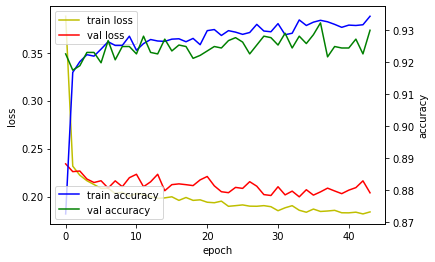

In [79]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label = 'train loss')
loss_ax.plot(history.history['val_loss'], 'r', label = 'val loss')

acc_ax.plot(history.history['accuracy'], 'b', label = 'train accuracy')
acc_ax.plot(history.history['val_accuracy'], 'g', label = 'val accuracy')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc = 'upper left')
acc_ax.legend(loc = 'lower left')

plt.show()